<h2 style="text-align: center">Used For Uptime Analysis</h2>

In [1]:
import pandas as pd

df = pd.read_csv('data_.csv')
df = df.drop(columns=['Data URI'])
df.head()

,Time,Content
0,2025-03-09T08:58:48.000Z,"{""devUI"":""08:D1:F9:35:B5:48"",""time_at_device"":..."
1,2025-03-09T08:59:00.000Z,"{""devUI"":""08:D1:F9:35:B5:48"",""time_at_device"":..."
2,2025-03-09T08:59:10.000Z,"{""devUI"":""08:D1:F9:35:B5:48"",""time_at_device"":..."
3,2025-03-09T08:59:18.000Z,"{""devUI"":""08:D1:F9:35:B5:48"",""time_at_device"":..."
4,2025-03-09T08:59:30.000Z,"{""devUI"":""08:D1:F9:35:B5:48"",""time_at_device"":..."


In [2]:
import json

def clean_json(text):
    try:
        return json.loads(text.replace("\n", "").replace("\r", "").strip())  # Hapus karakter newline dan spasi ekstra
    except json.JSONDecodeError:
        return None  # Jika gagal, isi dengan None

df["Content"] = df["Content"].apply(clean_json)
df = df.dropna(subset=["Content"])

# Ekstrak data JSON menjadi kolom sendiri
df_json = df["Content"].apply(pd.Series)
df = pd.concat([df.drop(columns=["Content"]), df_json], axis=1)

df.head()

,Time,devUI,time_at_device,time_received_at_gateway,time_send_from_gateway,RSSI,protocol,voltage,current,power,energy,frequency,power_factor
0,2025-03-09T08:58:48.000Z,08:D1:F9:35:B5:48,2025-03-09 08:58:32,2025-03-09 08:58:47,2025-03-09 08:58:47.872,-108,http,231.20,0.09,7.30,0.78,433000000.0,0.36
1,2025-03-09T08:59:00.000Z,08:D1:F9:35:B5:48,2025-03-09 08:58:42,2025-03-09 08:58:57,2025-03-09 08:58:57.224,-107,http,231.60,0.09,7.20,0.78,433000000.0,0.35
2,2025-03-09T08:59:10.000Z,08:D1:F9:35:B5:48,2025-03-09 08:58:53,2025-03-09 08:59:07,2025-03-09 08:59:07.592,-108,http,231.30,0.09,7.50,0.78,433000000.0,0.36
3,2025-03-09T08:59:18.000Z,08:D1:F9:35:B5:48,2025-03-09 08:59:03,2025-03-09 08:59:18,2025-03-09 08:59:18.967,-108,mqtt,230.90,0.09,7.20,0.78,433000000.0,0.35
4,2025-03-09T08:59:30.000Z,08:D1:F9:35:B5:48,2025-03-09 08:59:13,2025-03-09 08:59:28,2025-03-09 08:59:28.330,-108,mqtt,231.70,0.09,7.10,0.78,433000000.0,0.35


In [3]:
# Ubah kolom "Time" menjadi format datetime
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

# Tambahkan 1 detik ke semua baris
df["Time"] = df["Time"] + pd.Timedelta(seconds=1)

# Ubah kembali ke format string jika diperlukan
df["Time"] = df["Time"].dt.strftime("%Y-%m-%d %H:%M:%S")
df = df.rename(columns={"Time": "received_at_server"})

df.head()

,received_at_server,devUI,time_at_device,time_received_at_gateway,time_send_from_gateway,RSSI,protocol,voltage,current,power,energy,frequency,power_factor
0,2025-03-09 08:58:49,08:D1:F9:35:B5:48,2025-03-09 08:58:32,2025-03-09 08:58:47,2025-03-09 08:58:47.872,-108,http,231.20,0.09,7.30,0.78,433000000.0,0.36
1,2025-03-09 08:59:01,08:D1:F9:35:B5:48,2025-03-09 08:58:42,2025-03-09 08:58:57,2025-03-09 08:58:57.224,-107,http,231.60,0.09,7.20,0.78,433000000.0,0.35
2,2025-03-09 08:59:11,08:D1:F9:35:B5:48,2025-03-09 08:58:53,2025-03-09 08:59:07,2025-03-09 08:59:07.592,-108,http,231.30,0.09,7.50,0.78,433000000.0,0.36
3,2025-03-09 08:59:19,08:D1:F9:35:B5:48,2025-03-09 08:59:03,2025-03-09 08:59:18,2025-03-09 08:59:18.967,-108,mqtt,230.90,0.09,7.20,0.78,433000000.0,0.35
4,2025-03-09 08:59:31,08:D1:F9:35:B5:48,2025-03-09 08:59:13,2025-03-09 08:59:28,2025-03-09 08:59:28.330,-108,mqtt,231.70,0.09,7.10,0.78,433000000.0,0.35


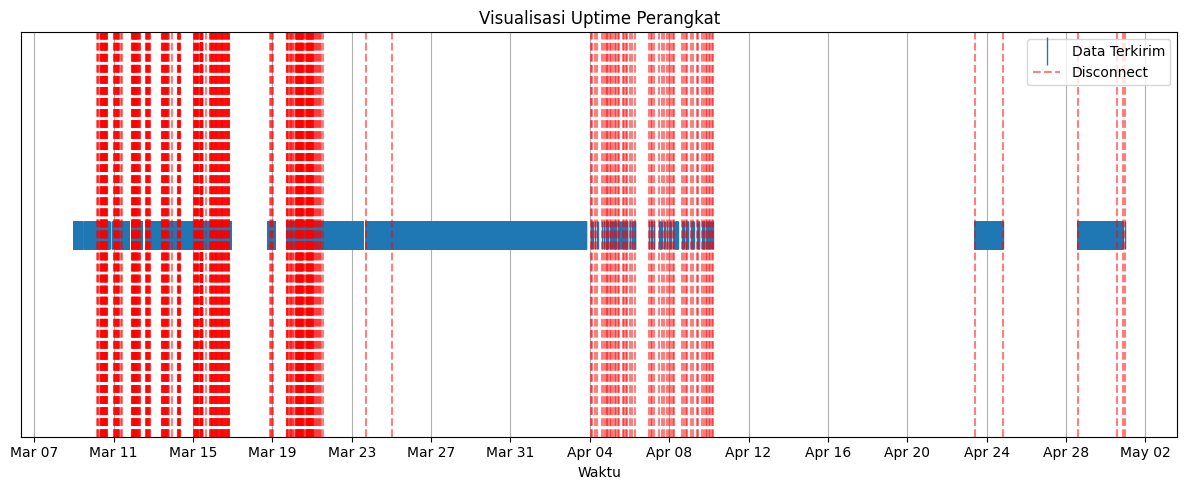

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df['timestamp'] = pd.to_datetime(df['received_at_server'])

# Hitung selisih waktu antar data
df['delta'] = df['timestamp'].diff()

# Tetapkan ambang batas waktu keterlambatan (misal: 10 menit)
threshold = pd.Timedelta(minutes=60)

# Tandai titik-titik disconnect
disconnects = df[df['delta'] > threshold]

# Plot semua timestamp sebagai titik
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], [1]*len(df), '|', markersize=20, label="Data Terkirim")

# Plot disconnect sebagai garis vertikal
for t in disconnects['timestamp']:
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.5, label="Disconnect" if t == disconnects['timestamp'].iloc[0] else "")

# Format sumbu X agar hanya menampilkan Bulan dan Tanggal
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # contoh: Mar 18
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))    # setiap 2 hari ditampilkan

plt.yticks([])  # Hilangkan sumbu Y karena tidak penting
plt.xlabel("Waktu")
plt.title("Visualisasi Uptime Perangkat")
plt.legend()
plt.tight_layout()
plt.grid(axis='x')
plt.show()


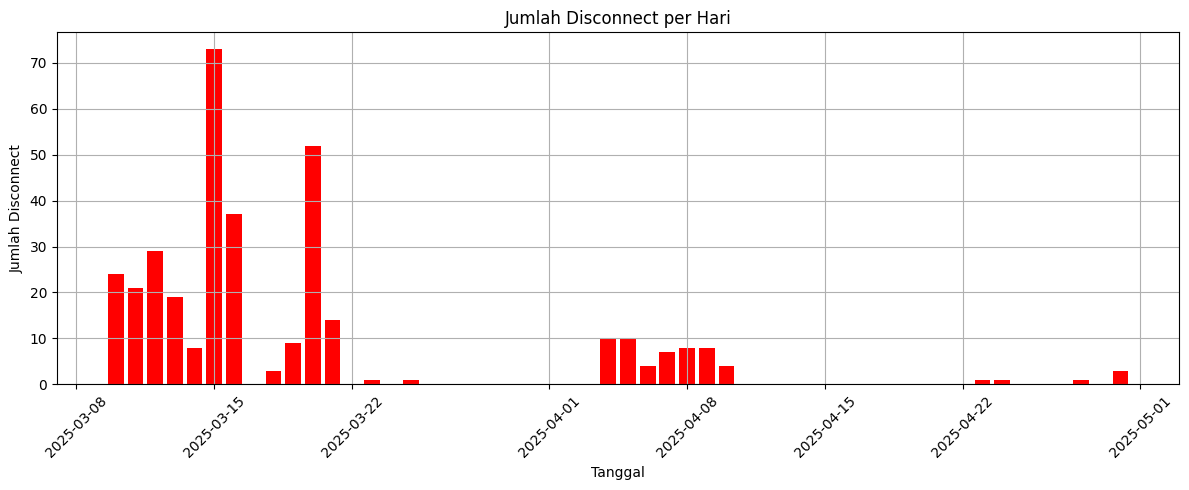

In [9]:
# Ambil waktu disconnect (selisih waktu terlalu lama)
disconnects = df[df['delta'] > threshold]

# Kelompokkan jumlah disconnect per hari
disconnects_per_day = disconnects['timestamp'].dt.date.value_counts().sort_index()

# Visualisasi
plt.figure(figsize=(12, 5))
plt.bar(disconnects_per_day.index, disconnects_per_day.values, color='red')
plt.xlabel("Tanggal")
plt.ylabel("Jumlah Disconnect")
plt.title("Jumlah Disconnect per Hari")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

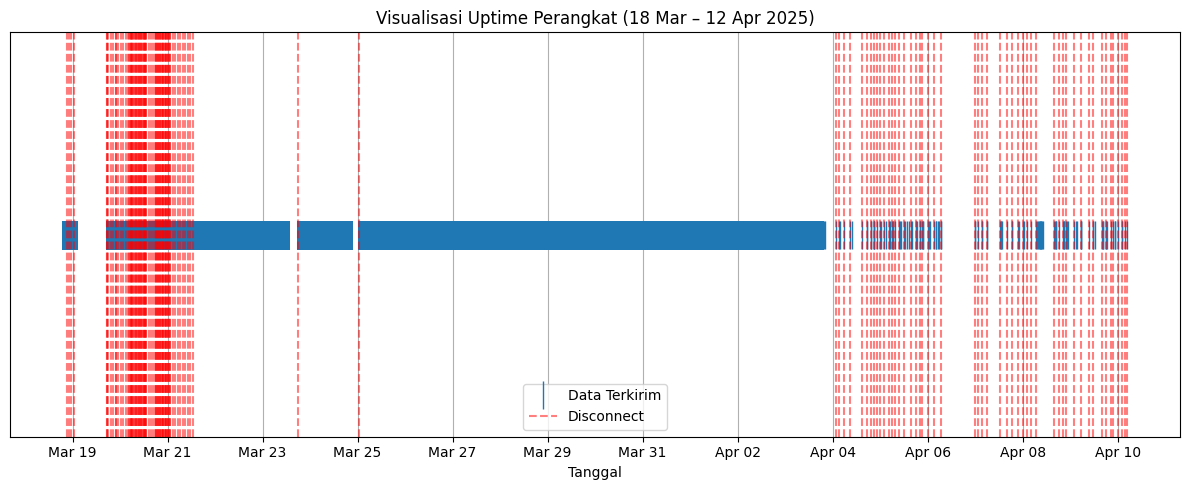

In [36]:
import matplotlib.dates as mdates

# Filter rentang tanggal
start_date = pd.to_datetime("2025-03-18")
end_date = pd.to_datetime("2025-04-12")
# Tetapkan ambang batas waktu keterlambatan (misal: 10 menit)
threshold = pd.Timedelta(minutes=10)

df_filtered = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]
disconnects_filtered = disconnects[(disconnects['timestamp'] >= start_date) & (disconnects['timestamp'] <= end_date)]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_filtered['timestamp'], [1]*len(df_filtered), '|', markersize=20, label="Data Terkirim")

for i, t in enumerate(disconnects_filtered['timestamp']):
    plt.axvline(x=t, color='red', linestyle='--', alpha=0.5, label="Disconnect" if i == 0 else "")

# Format sumbu X agar hanya menampilkan Bulan dan Tanggal
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # contoh: Mar 18
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))    # setiap 2 hari ditampilkan

plt.yticks([])
plt.xlabel("Tanggal")
plt.title("Visualisasi Uptime Perangkat (18 Mar – 12 Apr 2025)")
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()